In [12]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from enum import Enum

%matplotlib inline

<h1> Butterworth Filters </h1>

In this notebook, we perform some calculations to learn about Butterworth filters, including my own implementations of some digital butterworth filters and comparing to other implementations in python standard libraries.

<h2> History </h2>

The Butterworth filter was originally published in a 1930 paper by the physicist Stephen Butterworth in an attempt to simplify the construction of electric filters, which up until that point was usually done as almost an art - components were selected carefully and changed out until the desired filter performance was achieved. 

The original paper itself is pretty readable by today's standards and I highly recommend just giving the original a read in you have the chance:
[On the Theory of Filter Amplifiers](https://www.changpuak.ch/electronics/downloads/On_the_Theory_of_Filter_Amplifiers.pdf)

In [172]:
class FilterTypes(Enum):
    LOWPASS = 1
    HIGHPASS = 2
    BANDPASS = 3
    BANDSTOP = 4
    

def plot_filters(filters_, min_freq, max_freq, n=1000, plot_amplitude=True, plot_phase=True, 
                 step_response=False, plot_impulse=False, group_delay=False, plot_time=None):
    """
    Plot (potentially) everything there is to know about a set of filters - step response, group delay, phase delay,
        impulse response, phase response, amplitude response.
    
    By default, plots phase and amplitude of all filters in filters_
    """
    responses = []
    fig1, ax1 = plt.subplots()
    for i, filter_ in enumerate(filters_):
        f = np.logspace(np.log10(min_freq), np.log10(max_freq), n)
        responses.append(filter_.frequency_response(f))
        ax1.semilogx(f, 20 * np.log10(abs(responses[i])), label=f'{filter_}')
    ax1.set_title(f'Amplitude Spectra')
    ax1.set_xlabel('Frequency [Hz]')
    ax1.set_ylabel('Amplitude [dB]')
    ax1.margins(0, 0.1)
    ax1.grid(which='both', axis='both')
    ax1.legend()
    fig1.show()

    if plot_phase:
        fig2, ax2 = plt.subplots()
        for i in range(len(filters_)):
            ax2.semilogx(f, np.unwrap(np.angle(responses[i])*180.0/np.pi), label=f'{filter_}')
        ax2.set_title(f'Phase Spectra')
        ax2.set_xlabel('Frequency [Hz]')
        ax2.set_ylabel('phase [deg]')
        ax2.legend()
    
    if not plot_time:
        plot_time = 50/max_freq
    f_c = max_freq
    t_filter = plot_time
    t_samp = t_filter/100
    t = np.arange(-t_filter, t_filter, t_samp)
    
    if step_response:
        fig3, ax3 = plt.subplots()
        for filter_ in filters_:
            step_response = filter_.get_step_response(-t_filter, t_filter, t_samp, f_c)
            ax3.plot(t, np.real(step_response), label=f'{filter_} step response, real part')
        ax3.set_title(f'Step response')
        ax3.set_xlabel('Time (s)')
        ax3.set_ylabel('Amplitude')
        ax3.legend()
        
    if plot_impulse:
        fig4, ax4 = plt.subplots()
        for filter_ in filters_:
            impulse = filter_.get_impulse_response(-t_filter, t_filter, t_samp, f_c)
            ax4.plot(t, np.real(impulse), label=f'{filter_} step response, real part')
        ax4.set_title(f'Impulse response')
        ax4.set_xlabel('Time (s)')
        ax4.set_ylabel('Amplitude')
        ax4.legend()
            
class Filter():
        
    window = None
        
    def __init__(self):
        raise NotImplementedError
        
    def frequency_response(self, f):
        """
        Frequency response of filter at particular frequency or set of frequencies
        """
        return self.f_resp(f)
        
    def get_step_response(self, t):
        """
        Response of filter to a unit step in time
        """
        pass
        
    def get_impulse_response(self, f):
        """
        Response of filter
        """
        pass
    
    def fir(self, N, window=None):
        if not (window or self.window):
            pass
        """
        Return FIR implementation of the filter
        """
        pass

    
class RationalFilter(Filter):
    
    def __init__(self, dc_gain=1, poles=None, zeros=None):
        """
        Specifies a continuous-time linear time-invariant filter with a rational transfer function in terms of it's
        poles and zeros. Particularly, this specifies what it means to 
        
        poles: list of complex numbers, defining poles of the sequence. 
        """
        self._fir = None
        #assert poles or zeros
        if not poles:
            poles = []
        if not zeros:
            zeros = []
        
        self.poles = poles
        self.zeros = zeros
        self.dc_gain = dc_gain
        self.get_transfer_function()
        
    def get_transfer_function(self):
        
        def transfer_function(s):
            """
            s: numpy array of s-domain values to evaluate laplace transform at
            """
            response = self.dc_gain*np.ones(len(s))
            for pole in self.poles:
                response = response*pole/(pole - s)
            for zero in self.zeros:
                response = response*(zero - s)/zero
            return response
                
        self.transfer_function = transfer_function
            
    def f_resp(self, f):
        """
        f: np array of frequencies, in Hz
        """
        return self.transfer_function(1j*2*np.pi*f)

    def get_step_response(self, tmin, tmax, T_sample, f_cutoff=None):
        impulse_response = self.get_impulse_response(tmin, tmax, T_sample, f_cutoff)
        step_response = np.cumsum(impulse_response)*T_sample
        return step_response
        
    def get_impulse_response(self, tmin, tmax, T_sample, f_cutoff=None):
        if not f_cutoff:
            f_cutoff = 10/T_sample
        f = np.linspace(-f_cutoff, f_cutoff, 1000)
        df = 2*f_cutoff/1000
        t = np.arange(tmin, tmax, T_sample)
        impulse_response = np.zeros(len(t), dtype='complex')
        f_response = self.f_resp(f)
        phases = 1j*2*np.pi*f
        for i, time in enumerate(t):
            impulse_response[i] = np.sum(f_response*np.exp(phases*time))
        impulse_response /= (2*np.pi*df)
        return impulse_response
        
    def get_impulse_response_fft(self, tmin, tmax, T_sample, f_cutoff=None):
        raise NotImplementedError
        if tmin < 0:
            shift = -tmin
        n_samples = int((tmax - tmin)/T_sample)
        
    
        
class IIRDigitalFilter(RationalFilter):
    
    class Conversions(Enum):
        IMPULSE_INVARIANCE = 1
        MATCHED_Z = 2
        BILINEAR = 3
        
    """
    Define an IIR Digital Filter in terms of its continuous time equivalent
    
    Can construct the filter based on one of the following methods:
        Impulse Invariance: Constructs a filter equivalent to sampling
            the . 
        Matched-Z Transform: Maps the real line to the unit circle, wrapping
            . Poles and zeros in the s-plane are mapped to their equivalent
            in the z plane (e^(s_p*T) -> z)
        Bilinear Transform: linear, non-onto mapping from the real line
            to the unit circle. 
            
        Poles to be passed in are poles AS THEY WOULD APPEAR IN THE S-Plane
    """
    def __init__(self, conversion, dc_gain=1, Ts=None, poles=None, zeros=None):
        assert conversion in self.Conversions
        self.conversion = conversion
        if conversion == self.Conversions.IMPULSE_INVARIANCE:
            raise NotImplementedError
        super(IIRDigitalFilter, self).__init__(dc_gain, poles, zeros)
        self.Ts = Ts
        self.convert()
        self.get_transfer_function()
        
        
    @classmethod
    def from_continuous_filter(cls, filter_, conversion, Ts):
        poles = copy.deepcopy(filter_.poles)
        zeros = copy.deepcopy(filter_.zeros)
        dc_gain = filter_.dc_gain
        return cls(conversion, dc_gain, Ts, poles, zeros)
        
    def convert(self):
        """
        Convert form a continuous-time filter to a 
        """
        if self.conversion == self.Conversions.MATCHED_Z:
            iir_poles = []
            iir_zeros = []
            for pole in self.poles:
                iir_poles.append(np.exp(pole*self.Ts))
            for zeros in self.zeros:
                iir_zeros.append(np.exp(pole*self.Ts))
            self.poles = iir_poles
            self.zeros = iir_zeros
            
    def get_transfer_function(self):
        """
        Create the z_transform function
        """
        def z_transform(zs):
            """
            zs: numpy array of z values to evaluate
            """
            response = self.dc_gain*np.ones(len(zs))
            for pole in self.poles:
                response = response*zs*(1 - np.exp(pole*self.Ts))/(zs - np.exp(pole*self.Ts))
            for zero in self.zeros:
                response = response*(zs - np.exp(zero*self.Ts))/(zs*(1 - np.exp(zero*self.Ts)))
            return response
                
        self.z_transform = z_transform
            
    def f_resp(self, f):
        """
        f: np array of frequencies
        """
        return self.z_transform(np.exp(1j*2*np.pi*f))
        
    def get_step_response(self):
        pass

    
    
class ButterworthFilter(RationalFilter):
    
    def __init__(self, f_c, N, filter_type, bandwidth=None, dc_gain=1):
        assert filter_type in FilterTypes
        assert type(N) is int
        assert N > 0
        if filter_type in (FilterTypes.BANDPASS, FilterTypes.BANDSTOP):
            assert bandwidth is not None
        self._fir = None
        self.N = N
        self.f_c = f_c
        
        if filter_type is FilterTypes.LOWPASS:
            poles = []
            for i in range(self.N):
                poles.append(self._get_pole(self.N, f_c, i))
        
        super(ButterworthFilter, self).__init__(dc_gain=dc_gain, poles=poles, zeros=[])
        
    @static_method
    def _get_pole(N, f_c, i):
        """
        Returns N total equally spaced poles along the unit circle
        """
        phase_spacing = np.pi/N
        starting_phase = phase_spacing/2 + np.pi/2
        s_p = 2*np.pi*f_c*np.exp(1j*(starting_phase + phase_spacing*i))
        return s_p
            
    def __repr__(self):
        return f'Order {self.N} Butterworth Filter, f_c = {self.f_c}'
        
    
class ChebyshevFilter(RationalFilter):
    
    def __init__(self,  f_c, N, filter_type, bandwidth=None, dc_gain=1):
        assert filter_type in FilterTypes
        assert type(N) is int
        assert N > 0
        if filter_type in (FilterTypes.BANDPASS, FilterTypes.BANDSTOP):
            assert bandwidth is not None
        self._fir = None
        self.N = N
        self.f_c = f_c
        
        if filter_type is FilterTypes.LOWPASS:
            poles = []
            for i in range(self.N):
                poles.append(self._get_pole(self.N, f_c, i))
        
        super(ButterworthFilter, self).__init__(dc_gain=dc_gain, poles=poles, zeros=[])

    @static_method
    def _get_pole(N, f_c, i):
        """
        N is order
        i = Nth Pole
        """
        coeffs = np.zeros(N+1)
        coeffs[-1] = 1
        roots = np.polynomial.chebyshev.chebroots(coeffs)
        
        x = np.linspace(-1,1,100)
        y = np.ones(100)
        for root in a:
            y = y*(x - root)
        y = y/y[-1]
        
    


<ipython-input-172-aa403b4c4ecc>:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


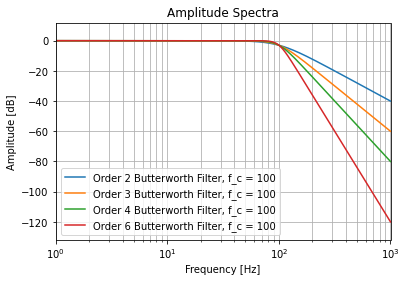

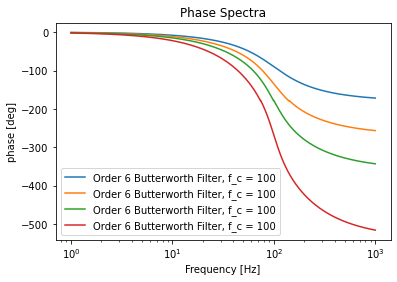

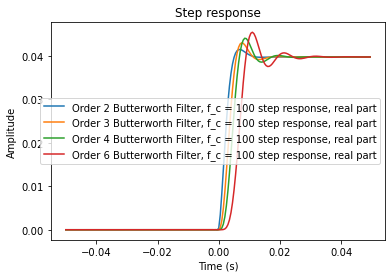

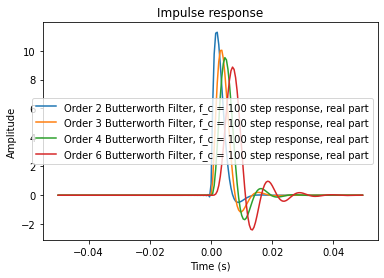

In [173]:
# Filter implemented as an FIR
N = 512  # Number of points in 
m = 4 # Order of filter
f_c = 100# Desired Cutoff frequency of filter 
f_s = 1000 # sampling rate


b2 = ButterworthFilter(f_c, 2, FilterTypes.LOWPASS, dc_gain=1)
b3 = ButterworthFilter(f_c, 3, FilterTypes.LOWPASS, dc_gain=1)
b4 = ButterworthFilter(f_c, 4, FilterTypes.LOWPASS, dc_gain=1)
b6 = ButterworthFilter(f_c, 6, FilterTypes.LOWPASS, dc_gain=1)
plot_filters([b2, b3, b4, b6], 1, 1000, plot_phase=True, plot_impulse=True, 
             step_response=True, plot_time=.05)



In [167]:
N = 4

In [170]:
x = np.linspace(-1,1,100)
y = np.ones(100)
for root in a:
    y = y*(x - root)
y = y/y[-1]

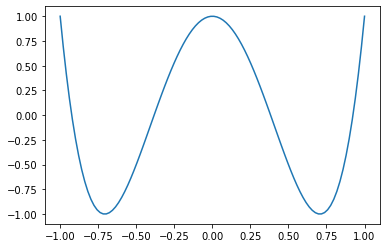

In [171]:
plt.plot(x, y)
plt.show()